In [2]:
import torch
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import accelerate
import evaluate
import gc
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from datasets import Dataset, Image, ClassLabel
from torch.utils.data import DataLoader

from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator)

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score)
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor)

In [3]:
from PIL import ImageFile

# Esta configuração permite que a biblioteca tente carregar imagens mesmo se elas estiverem corrompidas ou incompletas
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
import torch
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Carregar o modelo YOLO pré-treinado
model_yolo = fasterrcnn_resnet50_fpn(pretrained=True)
model_yolo.eval()

# Definir transformações para redimensionar e normalizar as imagens
transform_yolo = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Função para detectar objetos em uma imagem usando YOLO
def detect_objects_yolo(image):
    # Aplicar transformações à imagem
    image = transform_yolo(image).unsqueeze(0)

    # Executar inferência no modelo YOLO
    with torch.no_grad():
        prediction = model_yolo(image)

    return prediction

In [6]:
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd

# Inicializando as listas vazias p armazenar os nomes dos arquivos e dos rótulos
file_names = []
labels = []

# Iterando por todos os arquivos de imagem no diretório especificado
for file in sorted((Path('deepfake_database/deepfake_database').glob('*/*/*.*'))):
    parts = file.parts
    label = parts[-2]
    labels.append(label)
    file_names.append(str(file))

#  Printando o número total de nomes de arquivo e rótulos
print(len(file_names), len(labels))

# Criando dataframe a partir dos nomes de arquivo e rótulos coletados
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)


19457 19457
(19457, 2)


In [7]:
df.head()

,image,label
0,deepfake_database\deepfake_database\test\df\df...,df
1,deepfake_database\deepfake_database\test\df\df...,df
2,deepfake_database\deepfake_database\test\df\df...,df
3,deepfake_database\deepfake_database\test\df\df...,df
4,deepfake_database\deepfake_database\test\df\df...,df


In [8]:
df['label'].unique()

array(['df', 'real'], dtype=object)

In [9]:
# oversampling aleatório da classe minoritária
# 'y' contém a variável de destino (rótulo) que queremos prever
y = df[['label']]

# Removendo a coluna 'label' do DF p separar os recursos da variável de destino
df = df.drop(['label'], axis=1)

ros = RandomOverSampler(random_state=42)

# Usar o RandomOverSampler para resamplear o conjunto de dados, oversampling da classe minoritária
# 'df' contém os dados de recursos, e 'y_resampled' conterá a variável de destino resampleada
df, y_resampled = ros.fit_resample(df, y)

# Excluindo a variável original 'y' p economizar memória
del y

# Adicionando a variável de destino resampleada 'y_resampled' como uma nova coluna 'label' no DataFrame
df['label'] = y_resampled

# Excluindo a variável resampleada p economizar memória
del y_resampled

# GarbageCollector pra liberar a memória descartada
gc.collect()

print(df.shape)

(23018, 2)


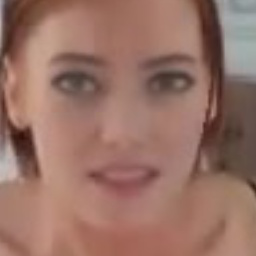

In [10]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

dataset[0]["image"]

In [11]:
# Extraindo os 5 primeiros elementos da lista criada
labels_subset = labels[:5]
print(labels_subset)

['df', 'df', 'df', 'df', 'df']


In [14]:
# Criando uma lista de rótulos únicos convertendo 'labels' para um conjunto e depois de volta para uma lista
labels_list = ['real', 'df']

# Inicializando os dicionários vazios p mapear os rótulos
label2id, id2label = dict(), dict()

# Iterando sobre os rótulos únicos e atribuindo a cada rótulo um ID, e vice-versa
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print("Mapeamento de IDs para Rótulos:", id2label, '\n')
print("Mapeamento de Rótulos para IDs:", label2id)

Mapeamento de IDs para Rótulos: {0: 'real', 1: 'df'} 

Mapeamento de Rótulos para IDs: {'real': 0, 'df': 1}


In [15]:
# Criando classlabels para corresponder rótulos a IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapeando rótulos -> IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)

# Dividindo o conjunto emtreinamento e teste (70-30)
dataset = dataset.train_test_split(test_size=0.3, shuffle=True, stratify_by_column="label")

train_data = dataset['train']
test_data = dataset['test']

Map:   0%|          | 0/23018 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/23018 [00:00<?, ? examples/s]

In [16]:
# definindo o ViT pré-treinado que vai ser utilizado
model_str = "dima806/deepfake_vs_real_image_detection" # 'vit-base-patch16-224-in21k'

# Criando um processador para a entrada do modelo
processor = ViTImageProcessor.from_pretrained(model_str)

# Recuperando a média e o desvio padrão da imagem usados para normalização
image_mean, image_std = processor.image_mean, processor.image_std

# Visualizando o a altura das imagens de entrada do modelo ViT
size = processor.size["height"]
print("Size: ", size)

# Transformação dos dados de treinamento
normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize((size, size)),        # Redimensionando as imagens para o tamanho de entrada do modelo
        RandomRotation(90),          # Aplicando rotação aleatória
        RandomAdjustSharpness(2),    # Ajustando nitidez aleatoriamente
        ToTensor(),                  # Convertendo as imagens para o formato do Tensor
        normalize                    # Normalizando as imagens usando média e desvio padrão
    ]
)

# Transformação dos dados de validação
_val_transforms = Compose(
    [
        Resize((size, size)),        # Redimensionando as imagens para o tamanho de entrada do modelo
        ToTensor(),                  # Convertendo as imagens para o formato do Tensor
        normalize                    # Normalizando as imagens usando média e desvio padrão
    ]
)

# Função p aplicar a TRANSFORMAÇÃO em um número x de exemplos
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Função p aplicar a VALIDAÇÃO em um número x de exemplos
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [13]:
# Setando as transfomrações para os dados de treinamento e dados de validação
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [14]:
# Função para preparar os dados em batch para o treinamento do modelo
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [15]:
# Criando um modelo a partir de um checkpoint do pré-treinamento com um número especificado de rótulos de saída
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configurando o mapeamento de rótulos de classe para seus índices correspondentes (usaremos isso mais p frente)
model.config.id2label = id2label
model.config.label2id = label2id

# Print para visualizarmos o número de parâmetros treinávei para o modelo
print(model.num_parameters(only_trainable=True) / 1e6)

85.800194


In [16]:
# Métrica de acurácia do módulo
accuracy = evaluate.load("accuracy")

# Função para calcular as métricas de avaliação
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids

    # Converter previsões do modelo em rótulos de classe, selecionando a classe com a probabilidade mais alta (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculando a pontuação comparando rótulos previstos com rótulos verdadeiros
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    return {
        "accuracy": acc_score
    }

In [17]:
metric_name = "accuracy"

# Nome do modelo 
# Esse será o nome do diretório que será criado, ele armazena tanto os checkpoints do treinamento quanto o treinamento completo do modelo
model_name = "deepfake_vs_real_image_detection"

num_train_epochs = 2

# Criar uma instância de TrainingArguments para configurar as configurações de treinamento.
args = TrainingArguments(
    output_dir=model_name, # Diretório onde checkpoints e saídas do modelo serão salvos.
    logging_dir='./logs',  # Diretório onde os logs de treinamento serão armazenados.
    evaluation_strategy="epoch", # Estratégia da avaliação, que é realizada no final de cada epoch
    learning_rate=1e-6,    # Taxa de aprendizado para o otimizador.
    per_device_train_batch_size=32, # Tamanho do lote para treinamento
    per_device_eval_batch_size=8, # Tamanho do lote para avaliação
    num_train_epochs=num_train_epochs, # Número total de treinamento para as epoch's
    weight_decay=0.02, # Aplicando decaimento de peso para evitar overfitting
    warmup_steps=50, # Número de etapas de aquecimento para o escalonador de taxa de aprendizado
    remove_unused_columns=False, # Desabilitando a opção de remover as colunas não utilizadas do conjunto
    save_strategy='epoch', # Definir a estratégia para salvar checkpoints do modelo (por época neste caso).
    load_best_model_at_end=True, # Carregar o melhor modelo no final do treinamento.
    save_total_limit=1, # Limitando úmero total de checkpoints salvos para economizar espaço

    report_to="none"
)

In [18]:
# Instância do "treinador" para ajustar a ML.

# - `model`: ML pré-treinado a ser ajustado
# - `args`: Configurações e hiperparâmetros para treinamento
# - `train_dataset`: Conjunto de dados usado para treinar o modelo
# - `eval_dataset`: Conjunto de dados usado para avaliar o modelo durante o treinamento
# - `data_collator`: Uma função que define como os lotes dos dados serão agrupados e processados
# - `compute_metrics`: Função para calcular métricas de avaliação personalizadas
# - `tokenizer`: Tokenizador usado para processar dados de texto

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [40]:
# Avaliar o desempenho do modelo de pré-treinamento em um conjunto de dados de teste.
# Essa função calcula várias métricas (acurácia, perda, etc), e gera quão bem o modelo está se saindo em relação aos dados não vistos
trainer.evaluate()

## Resultado utilizando SVC
#{'eval_loss': 2.5447912216186523,
# 'eval_accuracy': 0.45525629887054736,
# 'eval_runtime': 1313.291,
# 'eval_samples_per_second': 5.259,
# 'eval_steps_per_second': 0.658}

{'eval_loss': 2.5447912216186523,
 'eval_accuracy': 0.45525629887054736,
 'eval_runtime': 1137.414,
 'eval_samples_per_second': 6.072,
 'eval_steps_per_second': 0.76}

In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.768200,0.467214,0.798002
2,0.262700,0.371917,0.842021


TrainOutput(global_step=1008, training_loss=0.5128186787404712, metrics={'train_runtime': 15896.2486, 'train_samples_per_second': 2.027, 'train_steps_per_second': 0.063, 'total_flos': 2.4971018733406126e+18, 'train_loss': 0.5128186787404712, 'epoch': 2.0})

In [42]:
# Testando o modelo treinado em cima da nossa base de testes
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.3719169497489929, 'test_accuracy': 0.8420214306400232, 'test_runtime': 973.6002, 'test_samples_per_second': 7.093, 'test_steps_per_second': 0.887}


Accuracy: 0.8420
F1 Score: 0.8406


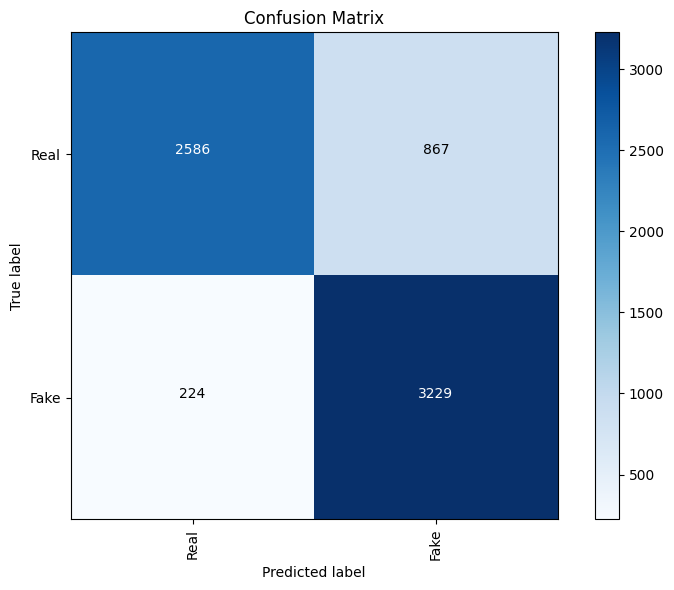


Classification report:

              precision    recall  f1-score   support

        Real     0.9203    0.7489    0.8258      3453
        Fake     0.7883    0.9351    0.8555      3453

    accuracy                         0.8420      6906
   macro avg     0.8543    0.8420    0.8406      6906
weighted avg     0.8543    0.8420    0.8406      6906



In [43]:
# Coletando os rótulos verdadeiros das saídas do modelo
y_true = outputs.label_ids

# Coletando as previsões dos rótulos selecionando a classe com a probabilidade mais alta
y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Matriz de Confusão', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    thresh = cm.max() / 2.0
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('Rótulo verdadeiro')
    plt.xlabel('Rótulo previsto')
    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precisão: {accuracy:.4f}")
print(f"Pontuação F1: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()

print("Relatório de classificação:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [44]:
# Esta linha de código é responsável por salvar o modelo que foi treinado. 
# O "trainer" serializará o modelo  e seus pesos associados, tornando possível 
# recarregar e usar o modelo no futuro sem a necessidade de treiná-lo novamente.
trainer.save_model()

In [48]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline

# Create a pipeline for image classification tasks.
# You need to specify the 'model_name' and the 'device' to use for inference.
# - 'model_name': The name of the pre-trained model to be used for image classification.
# - 'device': Specifies the device to use for running the model (0 for GPU, -1 for CPU).
pipe = pipeline('image-classification', model=model_name, device=-1)

In [95]:
print([test_data])

[Dataset({
    features: ['image', 'label'],
    num_rows: 6906
})]
